In [12]:
import pandas as pd
data = pd.read_excel('BMS-Public-Access-Dataset_1993-2022.xlsx')

print(data)


       studyid  time  site  criteria        age  age80up  alive_dc  consented  \
0            1     0   1.0       6.0  44.605064      0.0       1.0        1.0   
1            1     1   NaN       NaN        NaN      NaN       NaN        NaN   
2            1     2   NaN       NaN        NaN      NaN       NaN        NaN   
3            1     3   NaN       NaN        NaN      NaN       NaN        NaN   
4            1     5   NaN       NaN        NaN      NaN       NaN        NaN   
...        ...   ...   ...       ...        ...      ...       ...        ...   
28882     8865     0   6.0       5.0        NaN      NaN       1.0        2.0   
28883     8866     0   6.0       5.0  54.855579      0.0       1.0        1.0   
28884     8867     0   6.0       2.0  20.281998      0.0       1.0        1.0   
28885     8868     0   6.0       2.0        NaN      NaN       1.0        4.0   
28886     8869     0   6.0       2.0  23.233402      0.0       1.0        1.0   

       bth_year  brn_year  

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:


# Data Preprocessing: Filter initial visits (time == 0)
initial_visits = data[data['time'] == 0]
cleaned_data = initial_visits.dropna(thresh=0.5 * len(initial_visits), axis=1)

# Select relevant features and target, including 'age'
X = cleaned_data[['inhalinj', 'tbsabrn', 'othrinj', 'age']].fillna(0)
y = (cleaned_data['daysvent'] > 0).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print accuracy and classification report
print(f"Accuracy: {accuracy * 100:.2f}%")
print(report)


Accuracy: 86.19%
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1368
           1       0.77      0.56      0.65       406

    accuracy                           0.86      1774
   macro avg       0.83      0.76      0.78      1774
weighted avg       0.86      0.86      0.85      1774



In [37]:
def predict_icu():
    # Prompt the user for input values
    inhalinj = int(input("Enter Inhalation Injury (1 for No, 2 for Yes): "))
    tbsabrn = float(input("Enter Total Body Surface Area Burned (e.g., 25 for 25%): "))
    othrinj = int(input("Enter Other Injuries (1 for No, 2 for Yes): "))
    age = int(input("Enter Age: "))

    # Create a DataFrame for the input
    input_data = pd.DataFrame([[inhalinj, tbsabrn, othrinj, age]],
                              columns=['inhalinj', 'tbsabrn', 'othrinj', 'age'])

    # Make the prediction
    prediction = gb_model.predict(input_data)

    # Return the result
    if prediction[0] == 1:
        return 'ICU support needed'
    else:
        return 'ICU support not needed'

# Example usage of the prediction function
print(predict_icu())


Enter Inhalation Injury (1 for No, 2 for Yes): 2
Enter Total Body Surface Area Burned (e.g., 25 for 25%): 52
Enter Other Injuries (1 for No, 2 for Yes): 2
Enter Age: 35
ICU support needed


## Feature Importance

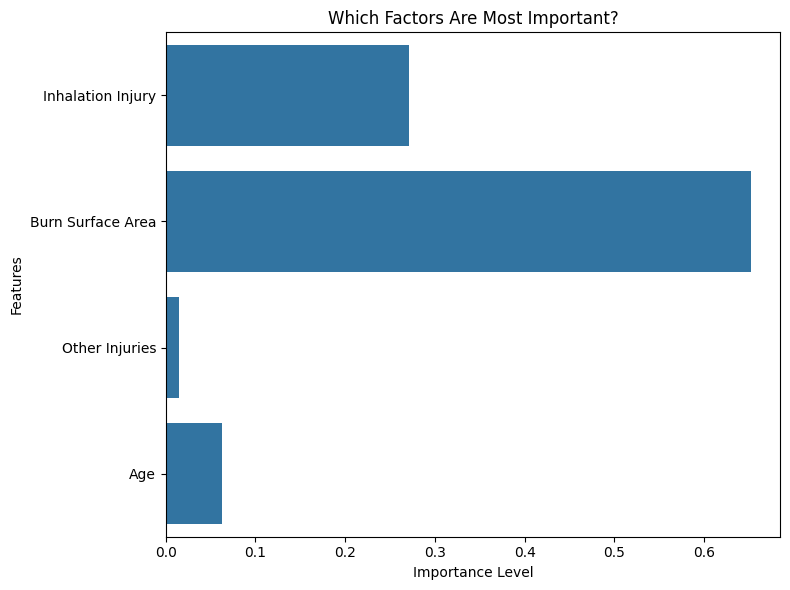

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=model.feature_importances_, y=feature_names)
    plt.title("Which Factors Are Most Important?")
    plt.xlabel("Importance Level")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

# Example usage
plot_feature_importance(gb_model, ['Inhalation Injury', 'Burn Surface Area', 'Other Injuries', 'Age'])


# Confusion Matrix:
Visually explain how well the model predicted ICU needs by comparing actual vs predicted outcomes.

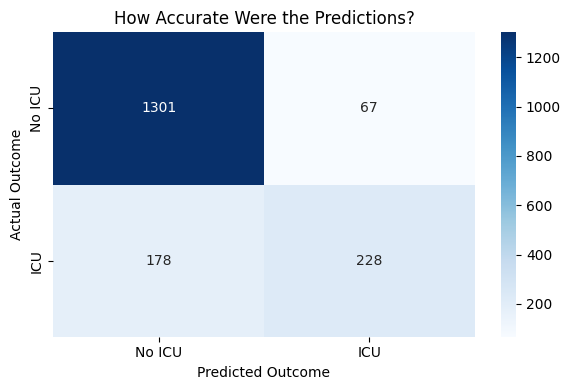

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No ICU', 'ICU'], yticklabels=['No ICU', 'ICU'])
    plt.title('How Accurate Were the Predictions?')
    plt.xlabel('Predicted Outcome')
    plt.ylabel('Actual Outcome')
    plt.tight_layout()
    plt.show()

# Example usage
plot_confusion_matrix(y_test, y_pred)


#ROC Curve:
This visual helps to explain how well the model is balancing between true positives and false positives.

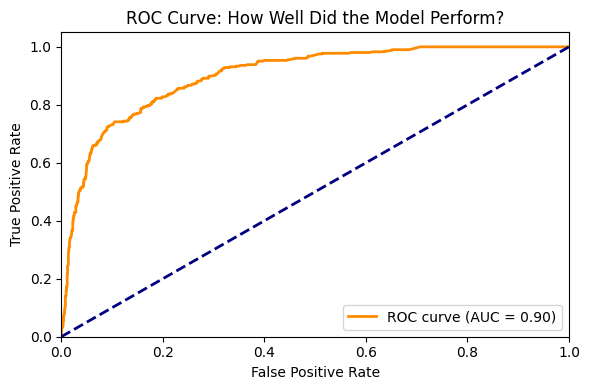

In [33]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: How Well Did the Model Perform?')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Example usage
plot_roc_curve(y_test, gb_model)


#Classification Report Visualization:
Show the precision, recall, and F1-score for each class using a visual heatmap to make it more intuitive.

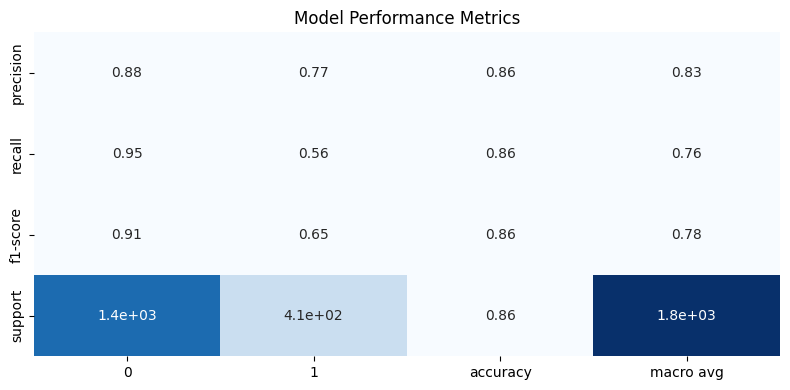

In [34]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Function to display classification report as heatmap
def show_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(8, 4))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
    plt.title('Model Performance Metrics')
    plt.tight_layout()
    plt.show()

# Example usage
show_classification_report(y_test, y_pred)


#Prediction Distribution:
This visualization helps to explain how well the model is balanced in terms of predicting ICU and non-ICU cases.

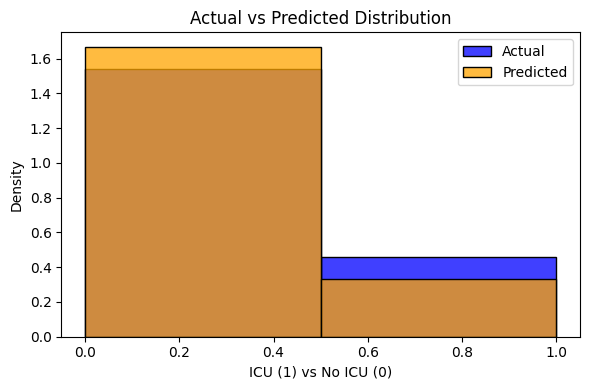

In [35]:
def plot_prediction_distribution(y_test, y_pred):
    plt.figure(figsize=(6, 4))
    sns.histplot(y_test, label="Actual", color="blue", kde=False, stat="density", bins=2)
    sns.histplot(y_pred, label="Predicted", color="orange", kde=False, stat="density", bins=2)
    plt.title("Actual vs Predicted Distribution")
    plt.legend()
    plt.xlabel("ICU (1) vs No ICU (0)")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

# Example usage
plot_prediction_distribution(y_test, y_pred)


#FINAL DASHBOARD

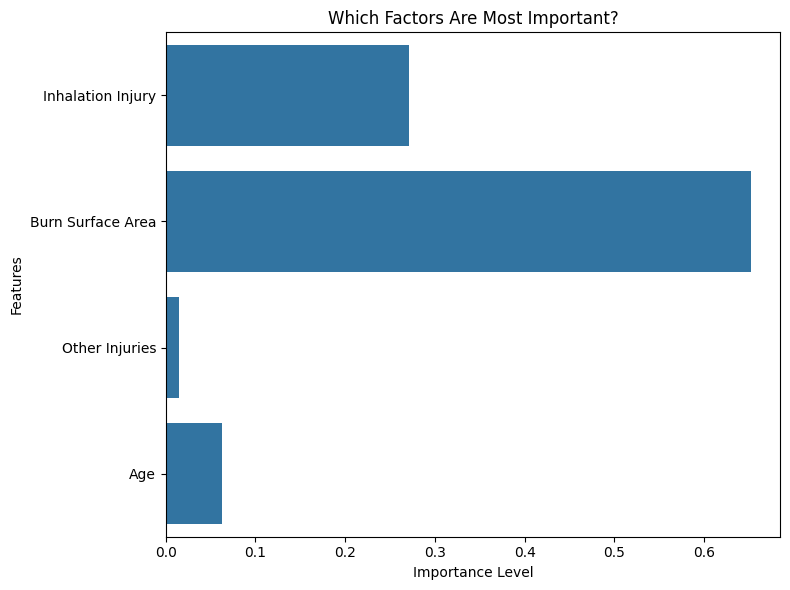

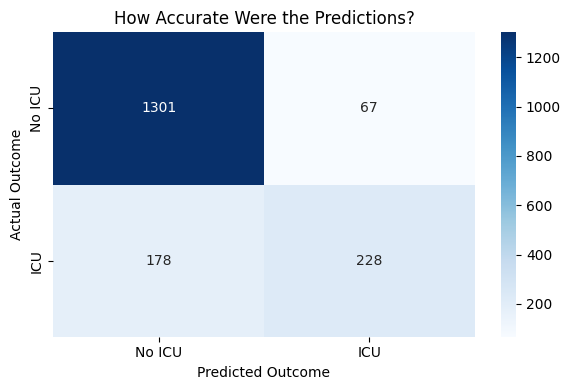

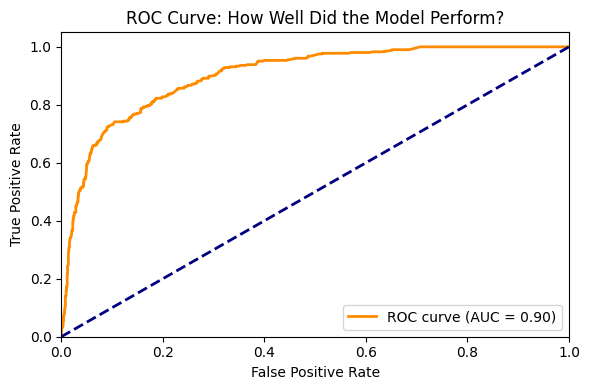

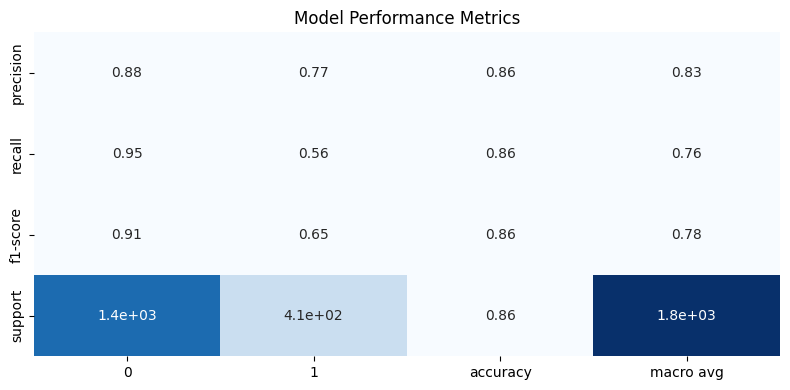

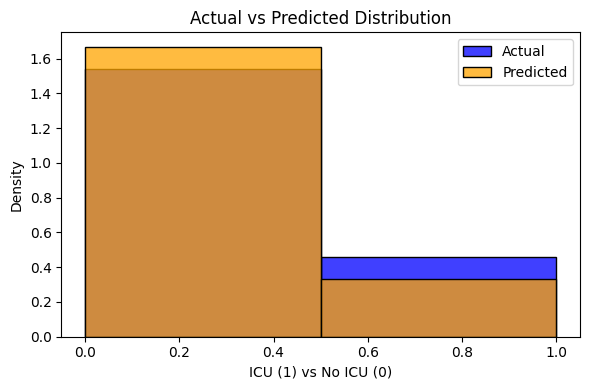

In [36]:
def present_dashboard():
    # Step 1: Show Feature Importance
    plot_feature_importance(gb_model, ['Inhalation Injury', 'Burn Surface Area', 'Other Injuries', 'Age'])

    # Step 2: Show Confusion Matrix
    plot_confusion_matrix(y_test, y_pred)

    # Step 3: Show ROC Curve
    plot_roc_curve(y_test, gb_model)

    # Step 4: Show Classification Report
    show_classification_report(y_test, y_pred)

    # Step 5: Show Prediction Distribution
    plot_prediction_distribution(y_test, y_pred)

# Run the dashboard presentation
present_dashboard()


In [40]:
# prompt: save the model I uilt

import pickle

# Save the trained model to a file
filename = 'gb_model.pkl'
pickle.dump(gb_model, open(filename, 'wb'))

print(f"Model saved to {'/content'}")


Model saved to /content
